In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

data = pd.read_pickle('../../geodata/results/05_lausanne_lisa_01july23.pkl')

In [173]:
sns.set_theme()
# sns.set_style('white')
sns.set_context("paper", font_scale = 1)

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\swietek\Miniconda3\envs\env_intel_sdb\lib\site-packages\mapclassify\classifiers.py:255: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 3.
  warnings.warn(


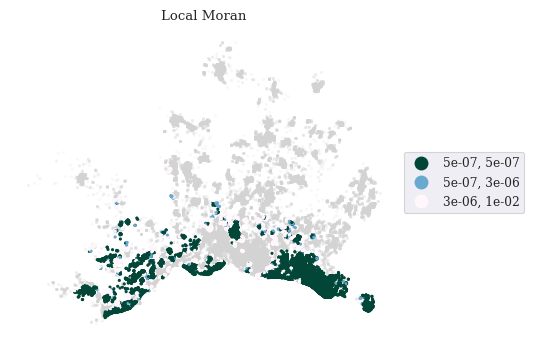

In [299]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
data.plot(ax = ax , color = 'lightgrey',alpha = .1, markersize = 2)
data.query('lisa_pvals <= .01').query('lisa_cluster == 1').plot(ax = ax, column = 'lisa_pvals', cmap = 'PuBuGn_r',
                                                                 legend=True,markersize = 2,scheme='QUANTILES',
                                                                 legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5),  'fmt':"{:.0e}"})


plt.title('Local Moran')
plt.axis('off')
plt.show()

In [8]:
from tqdm import tqdm
import hdbscan
import alphashape
from sklearn.cluster import DBSCAN

In [9]:
sig_lvl = .05 / data.shape[0]
sig_lvl


6.108586228803206e-07

In [10]:
hh_cluster = (data.query('lisa_pvals <= @sig_lvl')).query('lisa_cluster == 1')
clusterer = hdbscan.HDBSCAN(min_cluster_size=50, gen_min_span_tree=True).fit(hh_cluster[['FassPktX','FassPktY']].values)
hh_cluster['cluster_labels'] = clusterer.labels_

In [11]:
%%time
g_lst2 = []
for g_ix in tqdm(range(0, hh_cluster.cluster_labels.max()+1)):
#     print(g_ix)
    X = hh_cluster.query('cluster_labels == @g_ix')[['FassPktX','FassPktY']].values
    alpha_shape = alphashape.alphashape(X,.01)
    g_lst2.append(alpha_shape)

100%|██████████| 32/32 [00:03<00:00,  8.66it/s]

CPU times: total: 3.69 s
Wall time: 3.7 s


In [19]:
hh_cluster['cluster_labels'] = hh_cluster['cluster_labels'].astype('int')

c:\Users\swietek\Miniconda3\envs\env_intel_sdb\lib\site-packages\mapclassify\classifiers.py:255: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 1.
  warnings.warn(


(2510931.59649875, 2552817.1347262496, 1144329.6229249989, 1177736.3380249995)

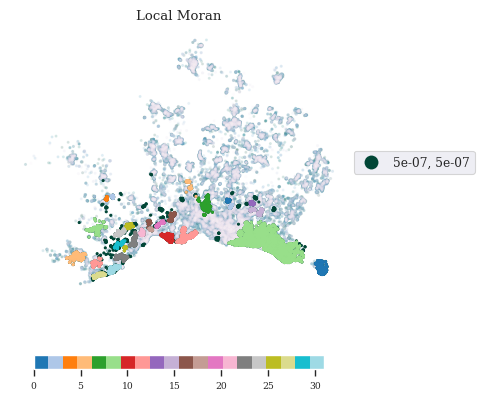

In [300]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
(data).plot(ax = ax , cmap = 'PuBuGn_r',alpha = .1, markersize = 2)
(hh_cluster.query('lisa_pvals <= @sig_lvl').query('lisa_cluster == 1')).plot(ax = ax, column = 'lisa_pvals', cmap = 'PuBuGn_r',legend=True,markersize = 2,scheme='QUANTILES',legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5),  'fmt':"{:.0e}"})
hh_cluster.query('cluster_labels != -1').plot(ax = ax, column = 'cluster_labels', cmap = 'tab20',legend=True,markersize = 2,legend_kwds={
        "location":"bottom",
        "shrink":.75
    })
plt.title('Local Moran')
plt.axis('off')

In [42]:
# ch_lake_geo = st_read('geodata/ch_lakes/ch_lakes.gpkg')
ch_agglo = gpd.read_file('../../geodata/ch_agglo/swiss_urban_agglomerations.gpkg')
ch_muni  = gpd.read_file('../../geodata/ch_gemeindetypen/ch_gemeindetypen_00_merged.gpkg')
ch_land  = gpd.read_file('../../geodata/ch_landtypo/landschaftstypen_2056.gpkg')
ch_income  = gpd.read_file('../../geodata/ch_districts/ch_income_per_commune_2018.gpkg')


In [44]:
lausanne_communes = data.GMDNAME.unique()
missing_gmdnames = data.loc[data.net_income_ptp.isnull(),'GMDNAME'].unique()


In [53]:
pal = ['#0099E6', '#12255A', '#F23814', '#DFB78B', '#B6C3C5']

In [110]:
import contextily as cx

In [218]:
import matplotlib.lines as mlines
import matplotlib.patheffects as pe

In [282]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

C:\Users\swietek\AppData\Local\Temp\ipykernel_10916\218934350.py:20: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.gca().get_legend_handles_labels()


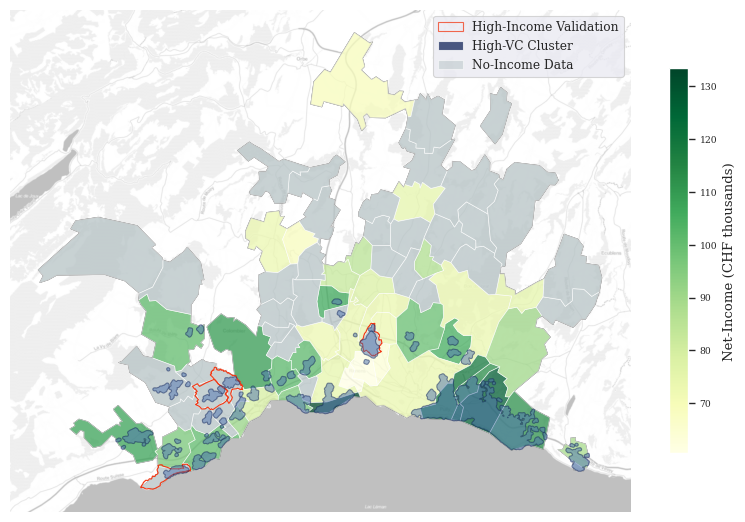

In [296]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ch_income['CLI'] = (ch_income.net_income_ptp/1000)#.astype(int)

ch_income.query('GMDNAME in @lausanne_communes').dissolve().plot(ax = ax, color='none', edgecolor = 'k', lw = .5)
ch_income.query('GMDNAME in @lausanne_communes').plot('CLI', cmap = 'YlGn', missing_kwds=dict(color = pal[4], edgecolor = 'white'), alpha = .75, edgecolor = 'white', lw =.5, legend = True, 
                                                      legend_kwds={"label": "Net-Income (CHF thousands)","location":"right",'shrink' : .5}, ax = ax)

ch_muni.query("GDE_NAME in @missing_gmdnames").query('TYP_00 == "Einkommensstarke Gemeinden (RE)"').plot(edgecolor = pal[2],facecolor = 'none', ax = ax, label = 'High-Income Validation')

# ch_income.query('GMDNAME in @lausanne_communes').plot(ax = ax,color = 'none', edgecolor = 'white', missing_kwds=dict(color = 'lightgrey'), alpha=1,legend = True, label = '')
gpd.GeoSeries(g_lst2, crs=data.crs).buffer(100).plot(ax = ax, edgecolor = pal[1]  , alpha = .5 ,  label = 'High-VC Clusters')
# gpd.GeoSeries(g_lst2, crs=data.crs).buffer(100).plot(ax = ax, edgecolor = pal[1]  , facecolor = 'none' )


legend_elements = [
                    Patch(facecolor='none', edgecolor = pal[2], alpha = .75,label='High-Income Validation'),
                   Patch(facecolor=pal[1], alpha = .75,label='High-VC Cluster'),
                   Patch(facecolor=pal[4], alpha = .5,label='No-Income Data')]
ax.legend(handles=legend_elements, loc='best',bbox_to_anchor = (1,1),title='', title_fontsize=10)
plt.gca().get_legend_handles_labels()

cx.add_basemap(ax, crs=data.crs.to_string(), source=cx.providers.Stamen.Toner, alpha = .25,  zoom = 12,attribution = "")
plt.axis('off')

plt.savefig('../../figs/lausanne_lisa.jpg', dpi = 300, bbox_inches='tight')

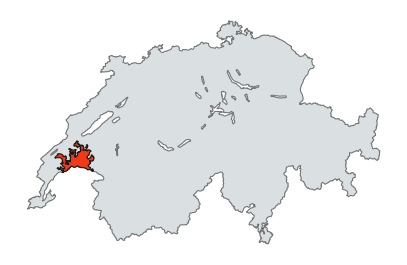

In [292]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

ch_income.dissolve().plot(color = pal[4], edgecolor = 'black', alpha = .5,ax = ax)

ch_agglo.query('Agglo_Name == "Lausanne"').dissolve().plot(ax = ax, color = pal[2], edgecolor = 'k')

plt.axis('off')

plt.savefig('../../figs/lausanne_is_here.jpg', dpi = 300, bbox_inches='tight')

In [ ]:
ch_income.query('GMDNAME in @lausanne_communes').cx(xmin)

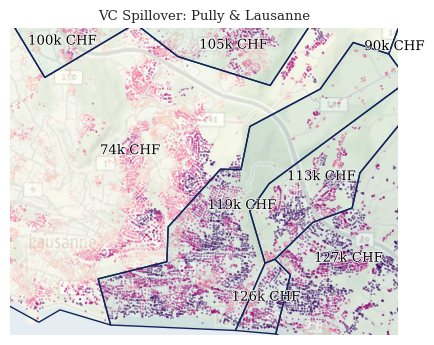

In [298]:
xmin, ymin= 2537341,1150506
xmax, ymax= 2543341,1155258

fig, ax = plt.subplots(1,1, figsize=(5,5))

data['mm_pred'] = (data.XGB - data.XGB.min())/(data.XGB.max() - data.XGB.min())
data['mm_nz'] = (data.nz - data.nz.min())/(data.nz.max() - data.nz.min())

data.plot('mm_nz', ax = ax, cmap = 'RdPu', edgecolor = 'none', alpha = .5, s = 2, scheme = 'naturalbreaks')
ch_income.query('GMDNAME in @lausanne_communes').plot('net_income_ptp', cmap = 'YlGn',  alpha = .1, lw =.5, legend = False, ax = ax)
ch_income.query('GMDNAME in @lausanne_communes').plot( edgecolor = pal[1], facecolor = 'none', alpha = 1, lw =1, legend = False, ax = ax)

ch_income['CLI'] = (ch_income.net_income_ptp/1000)#.astype(int)
from shapely.geometry import box
bbox = box(*[xmin, ymin, xmax, ymax])
df_clipped = gpd.clip(ch_income, bbox)
df_clipped.reset_index().apply(lambda x: ax.annotate(text=f'{x.CLI:.0f}k CHF',
                    color = 'black',#color_palette[1],
                    xy =( x.geometry.centroid.coords[0][0],x.geometry.centroid.coords[0][1]),
                    # xy=(x.geometry.centroid.coords[0][0]-9500,x.geometry.centroid.coords[0][1]+6500), 
                    ha='center',path_effects=[pe.withStroke(linewidth=1, foreground='white')]
                    ),axis=1)


ax.set_xlim(xmin, xmax), ax.set_ylim(ymin, ymax)
cx.add_basemap(ax, crs=data.crs.to_string(), source=cx.providers.Stamen.Terrain, alpha = .25,  zoom = 13,attribution = "")

ax.set_title('VC Spillover: Pully & Lausanne')
plt.axis('off')

plt.savefig('../../figs/spillover_lausanne_pully.jpg', dpi = 300, bbox_inches = 'tight')

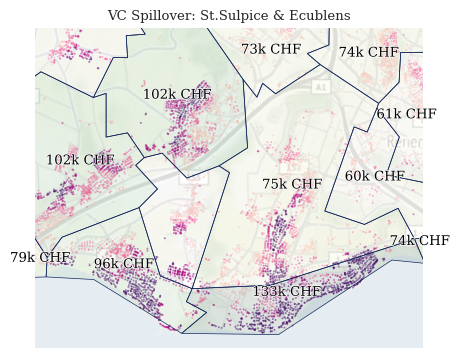

In [294]:
# comms = ["Saint-Sulpice (VD)","Préverenges"]
# xmin, ymin, xmax, ymax = ch_income.query('GMDNAME in @comms').dissolve().total_bounds

xmin, ymin= 2528814,1150856
xmax, ymax= 2534581,1155623

fig, ax = plt.subplots(1,1, figsize=(5,5))

data['mm_pred'] = (data.XGB - data.XGB.min())/(data.XGB.max() - data.XGB.min())
data['mm_nz'] = (data.nz - data.nz.min())/(data.nz.max() - data.nz.min())

data.plot('mm_nz', ax = ax, cmap = 'RdPu', edgecolor = 'none', alpha = .5, s = 2, scheme = 'naturalbreaks')
ch_income.query('GMDNAME in @lausanne_communes').plot('net_income_ptp', cmap = 'YlGn',  alpha = .1, lw =.5, legend = False, ax = ax)
ch_income.query('GMDNAME in @lausanne_communes').plot( edgecolor = pal[1], facecolor = 'none', alpha = 1, lw =.5, legend = False, ax = ax)

ch_income['CLI'] = (ch_income.net_income_ptp/1000)#.astype(int)
from shapely.geometry import box
bbox = box(*[xmin, ymin, xmax, ymax])
df_clipped = gpd.clip(ch_income, bbox)
df_clipped.query('CLI > 0').reset_index().apply(lambda x: ax.annotate(text=f'{x.CLI:.0f}k CHF',
                    color = 'black',#color_palette[1],
                    xy =( x.geometry.centroid.coords[0][0],x.geometry.centroid.coords[0][1]),
                    # xy=(x.geometry.centroid.coords[0][0]-9500,x.geometry.centroid.coords[0][1]+6500), 
                    ha='center',path_effects=[pe.withStroke(linewidth=1, foreground='white')]
                    ),axis=1)


ax.set_xlim(xmin, xmax), ax.set_ylim(ymin, ymax)
cx.add_basemap(ax, crs=data.crs.to_string(), source=cx.providers.Stamen.Terrain, alpha = .25,  zoom = 13,attribution = "")

ax.set_title('VC Spillover: St.Sulpice & Ecublens')
plt.axis('off')

plt.savefig('../../figs/spillover_sulpice_ecublens.jpg', dpi = 300, bbox_inches = 'tight')

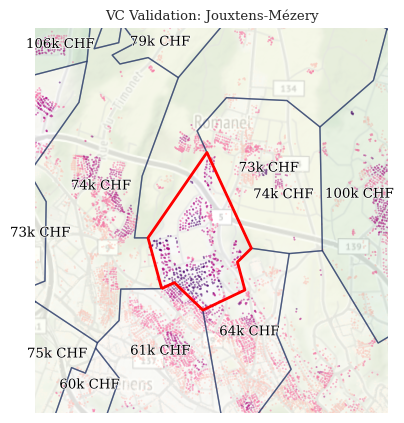

In [295]:
xmin, ymin= 2533052,1153508#2534033,1154489
xmax, ymax= 2538021,1158932# 2536619,1157673
fig, ax = plt.subplots(1,1, figsize=(5,5))

data['mm_pred'] = (data.XGB - data.XGB.min())/(data.XGB.max() - data.XGB.min())
data['mm_nz'] = (data.nz - data.nz.min())/(data.nz.max() - data.nz.min())

data.plot('mm_nz', ax = ax, cmap = 'RdPu', edgecolor = 'none', alpha = .5, s = 2, scheme = 'naturalbreaks')
ch_income.query('GMDNAME in @lausanne_communes').plot('net_income_ptp', cmap = 'YlGn',  alpha = .1, lw =.5, legend = False, ax = ax)
ch_income.query('GMDNAME in @lausanne_communes').plot( edgecolor = pal[1], facecolor = 'none', alpha = .5, lw =1, legend = False, ax = ax)
ch_income.query('GMDNAME == "Jouxtens-Mézery"').plot(edgecolor = 'red', facecolor = 'none', alpha = 1, lw =2, legend = False, ax = ax)


ch_income['CLI'] = (ch_income.net_income_ptp/1000)#.astype(int)
from shapely.geometry import box
bbox = box(*[xmin, ymin, xmax, ymax])
df_clipped = gpd.clip(ch_income, bbox)
df_clipped.query('CLI > 0').reset_index().apply(lambda x: ax.annotate(text=f'{x.CLI:.0f}k CHF',
                    color = 'black',#color_palette[1],
                    xy =( x.geometry.centroid.coords[0][0],x.geometry.centroid.coords[0][1]),
                    # xy=(x.geometry.centroid.coords[0][0]-9500,x.geometry.centroid.coords[0][1]+6500), 
                    ha='center',path_effects=[pe.withStroke(linewidth=1, foreground='white')]
                    ),axis=1)


ax.set_xlim(xmin, xmax), ax.set_ylim(ymin, ymax)
cx.add_basemap(ax, crs=data.crs.to_string(), source=cx.providers.Stamen.Terrain, alpha = .25,  zoom = 13,attribution = "")

ax.set_title('VC Validation: Jouxtens-Mézery')
plt.axis('off')
plt.savefig('../../figs/validation_jouxten_mezery.jpg', dpi = 300, bbox_inches = 'tight')

In [272]:
xmin, ymin= 2533052,1153508#2534033,1154489
xmax, ymax= 2538021,1158932# 2536619,1157673
fig, ax = plt.subplots(1,1, figsize=(5,5))

data['mm_pred'] = (data.XGB - data.XGB.min())/(data.XGB.max() - data.XGB.min())
data['mm_nz'] = (data.nz - data.nz.min())/(data.nz.max() - data.nz.min())

data.plot('mm_nz', ax = ax, cmap = 'RdPu', edgecolor = 'none', alpha = .5, s = 2, scheme = 'naturalbreaks')
ch_income.query('GMDNAME in @lausanne_communes').plot('net_income_ptp', cmap = 'YlGn',  alpha = .1, lw =.5, legend = False, ax = ax)
ch_income.query('GMDNAME in @lausanne_communes').plot( edgecolor = pal[1], facecolor = 'none', alpha = 1, lw =1, legend = False, ax = ax)
ch_income.query('GMDNAME == "Jouxtens-Mézery"').plot(edgecolor = 'red', facecolor = 'none', alpha = 1, lw =1, legend = False, ax = ax)


ch_income['CLI'] = (ch_income.net_income_ptp/1000)#.astype(int)
from shapely.geometry import box
bbox = box(*[xmin, ymin, xmax, ymax])
df_clipped = gpd.clip(ch_income, bbox)
df_clipped.query('CLI > 0').reset_index().apply(lambda x: ax.annotate(text=f'{x.CLI:.0f}k CHF',
                    color = 'black',#color_palette[1],
                    xy =( x.geometry.centroid.coords[0][0],x.geometry.centroid.coords[0][1]),
                    # xy=(x.geometry.centroid.coords[0][0]-9500,x.geometry.centroid.coords[0][1]+6500), 
                    ha='center',path_effects=[pe.withStroke(linewidth=1, foreground='white')]
                    ),axis=1)


ax.set_xlim(xmin, xmax), ax.set_ylim(ymin, ymax)
cx.add_basemap(ax, crs=data.crs.to_string(), source=cx.providers.Stamen.Terrain, alpha = .25,  zoom = 13,attribution = "")

ax.set_title('Validation: Jouxtens-Mézery')
plt.axis('off')


array(['Bioley-Orjulaz', 'Lully (VD)', 'Vuarrens', 'Jorat-Mézières',
       'Buchillon', 'La Sarraz', 'Pampigny', 'Aclens', 'Cugy (VD)',
       'Vufflens-le-Château', 'Bussy-Chardonney', 'Chigny', 'Penthaz',
       'Froideville', 'Jouxtens-Mézery', 'Montilliez', 'Assens',
       'Morrens (VD)', 'Servion', 'Vufflens-la-Ville', 'Yens', 'Bercher',
       'Denges', 'Montricher', 'Etagnières', 'Bottens', 'Denens', 'Rivaz',
       'Eclépens', 'Poliez-Pittet', 'Daillens', 'Jorat-Menthue',
       'Gollion', 'Villars-le-Terroir', 'Villars-Sainte-Croix',
       'Villars-sous-Yens', 'Bremblens', 'Lussy-sur-Morges',
       'Saint-Barthélemy (VD)', 'Romanel-sur-Morges'], dtype=object)